<a href="https://colab.research.google.com/github/monjjjjj/orchid_classification/blob/main/orchid_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.python import keras
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 
from tensorflow import keras
from google.colab import drive
from google.colab.patches import cv2_imshow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras import initializers, optimizers
from keras.layers import Dense, Flatten, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.resnet import ResNet50
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

In [2]:
# google drive mounted
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# data path
train_dir = "/content/drive/MyDrive/orchid_classification/training/"
label_dir = "/content/drive/MyDrive/orchid_classification/label/label.csv"

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [4]:
# read data
def load_data():
  x_train = []
  y_train = []
  df = pd.read_csv(label_dir, index_col = "filename")
  for p in os.listdir(train_dir):
    if p != "label.csv":
      path = train_dir + p
      image = cv2.imread(path)
      image = image.astype("float") / 255.0
      image = cv2.resize(image, IMG_SIZE, interpolation = cv2.INTER_AREA)
      x_train.append(np.array(image))
      y_train.append(df.loc[str(p),"category"])
  return x_train,y_train



In [5]:
# load data
x_train, y_train = load_data()

# one-hot encoding
x_train = np.array(x_train)
num_classes = 219
y_train = np_utils.to_categorical(y_train, num_classes, dtype = 'float32')

In [6]:
# debug
#print(x_train[1:5])
#print(y_train[1:5])
#print(x_train.shape)
#print(y_train.shape)

In [7]:
# spilt data
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_train, y_train, train_size=0.8, test_size=0.2, random_state=0)

In [8]:
# autotune
'''
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
'''

'\nAUTOTUNE = tf.data.AUTOTUNE\ntrain_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)\n'

In [9]:
'''
# data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])
'''

"\n# data augmentation\ndata_augmentation = tf.keras.Sequential([\n  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),\n  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),\n])\n"

In [10]:
'''
#data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)
'''

'\n#data augmentation\ndatagen = ImageDataGenerator(\n        featurewise_center=False,  # set input mean to 0 over the dataset\n        samplewise_center=False,  # set each sample mean to 0\n        featurewise_std_normalization=False,  # divide inputs by std of the dataset\n        samplewise_std_normalization=False,  # divide each input by its std\n        zca_whitening=False,  # apply ZCA whitening\n        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)\n        zoom_range = 0.2, # Randomly zoom image \n        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)\n        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)\n        horizontal_flip = True,  # randomly flip images\n        vertical_flip=False)  # randomly flip images\n\n\ndatagen.fit(x_train)\n'

In [11]:
# build model
def build_model():
  model = Sequential()
  model.add(ResNet50(include_top=False, weights='imagenet', input_tensor=None, pooling='avg', classes=219, input_shape=(224, 224, 3)))
  model.add(Flatten())
  model.add(Dense(219,activation='softmax'))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  print(model.summary())
  keras.utils.plot_model(model, show_shapes=True, dpi=64, to_file='model2.png')

  return model

In [12]:
#training
model = build_model()

train_history = model.fit(x=x_train, y=y_train, batch_size= BATCH_SIZE, epochs=20, verbose=1)


94781440/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 219)               448731    
                                                                 
Total params: 24,036,443
Trainable params: 23,983,323
Non-trainable params: 53,120
_________________________________________________________________
None
Epoch 1/20
69/69 [==============================] - 40s 325ms/step - loss: 5.0030 - accuracy: 0.0612
Epoch 2/20
69/69 [==============================] - 22s 315ms/step - loss: 3.2131 - accuracy: 0.2219
Epoch 3/20
69/69 [=============

In [13]:
print(train_history.history.keys())

dict_keys(['loss', 'accuracy'])


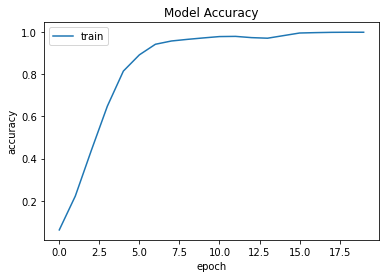

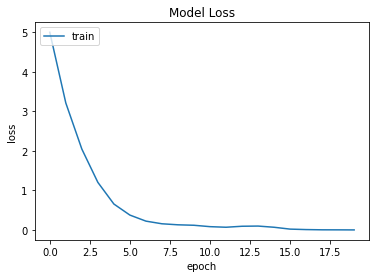

In [14]:
def show_train_history(train_history,train,validation):
  
  if train == 'accuracy':
    plt.plot(train_history.history[train])
    #plt.plot(train_history.history[validation])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
  else:
    plt.plot(train_history.history[train])
    #plt.plot(train_history.history[validation])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')

  plt.legend(['train','validation'],loc='upper left')
  plt.show()

show_train_history(train_history,'accuracy','val_accuracy')
show_train_history(train_history,'loss','val_loss')

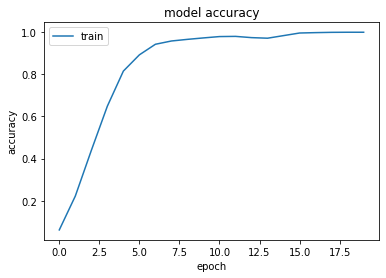

In [15]:
# summarize history for accuracy
plt.plot(train_history.history['accuracy'])
#plt.plot(train_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left') 
plt.show()